# Imports 

In [3]:
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
from jax import grad
import jax
import numpy as np
%matplotlib inline
from grad import *
from model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test of my autodiff library 

In [4]:
'''
This bit deals with how the computation graph is managed. The two outputs should be the same.

Here, Number is my from-near-scratch autodiff library, kind of like how torch.tensor() is
'''
x1 = Number(1)
x2 = Number(2)
x3 = Number(3)
x4 = Number(4)
x5 = Number(5)

y = (x1+x2)*x5 - x3
top_sorted = topo_sort(y)

print("Topologically sorted Values: ", top_sorted)

y.null_gradients()

for num in top_sorted:
    num.backprop_single()
    
print("Backprop with topological sort", [(i.grad, i) for i in top_sorted])

y.null_gradients()
y.backprop()

print("Backprop from the value", [(i.grad, i) for i in top_sorted])

Topologically sorted Values:  [Number(12), Number(3), Number(15), Number(5), Number(3), Number(2), Number(1)]
Backprop with topological sort [(1, Number(12)), (-1, Number(3)), (1, Number(15)), (3, Number(5)), (5, Number(3)), (5, Number(2)), (5, Number(1))]
Backprop from the value [(1, Number(12)), (-1, Number(3)), (1, Number(15)), (3, Number(5)), (5, Number(3)), (5, Number(2)), (5, Number(1))]


In [5]:
'''
For the next 3 cells, me and jax compare values on functions critical to neural networks.
'''

testmine = Number(2.)
mysigmoid = 1/(1+math.e**-testmine)

mysigmoid.backprop(should_print=False)

def jaxsigmoidsum(x):
    x = jnp.sum(x)
    return 1 / (1 + jnp.exp(-x)) 

testjax = jnp.array([2.]) 
sigmoided_value, grads = jax.value_and_grad(jaxsigmoidsum, argnums=(0))(testjax)

print(f"value comparison:", f"Mine {mysigmoid}", f"Jax {sigmoided_value}")
print(f"Grad comparison:", f"Mine {[testmine.grad]}", f"Jax{grads}")

value comparison: Mine Number(0.8807970779778823) Jax 0.8807970285415649
Grad comparison: Mine [0.1049935854035065] Jax[0.10499357]


In [6]:
def jax_sigmoid(x):
    return jnp.vectorize(lambda x: 1/(1+math.e**-x))(x)

def jax_weight_matrix(shape, naive=False):
    """weight matrix thingy.give dims. Not 0."""
    number = 1
    if(type(shape) == int):
        shape = [shape]
    for i in shape:
        number*= i
    if naive:
        return jnp.array([(i / 10) for i in range(number)]).reshape(*shape)
    return np.array([np.random.uniform(low=-.2, high=.2, size=None) for i in range(number)]).reshape(*shape)
    # return np.array([variable(np.random.uniform(low=-.2, high=.2, size=None)) for i in range(sizes[0] * sizes[1])).reshape(*shape)

In [7]:
test_shape = (3,5)
test_jax = jax_weight_matrix(test_shape, naive=True)
test_mine = weight_matrix(test_shape, naive=True)
test_shape2 = (5, 2)
test_jax2 = jax_weight_matrix(test_shape2, naive=True)
test_mine2 = weight_matrix(test_shape2, naive=True)

my_matmul = np.sum(test_mine @ test_mine2)
def j_matmul(a, b):
    thing = a @ b
    return jnp.sum(thing)


print("My value" , my_matmul)
print("Jax's value", j_matmul(test_jax, test_jax2))

j_matmuled, grads = jax.value_and_grad(j_matmul, argnums=(0, 1))(test_jax, test_jax2)

my_matmul.backprop()

print("Jax's grads" , grads[1].flatten())
print("My grads", [thing.grad for thing in test_mine2.flat])
#These match almost exactly! Yay! Please don't ask about the formatting

My value Number(10.65)
Jax's value 10.65
Jax's grads [1.5       1.5       1.8000001 1.8000001 2.1       2.1       2.4
 2.4       2.6999998 2.6999998]
My grads [1.5, 1.5, 1.8, 1.8, 2.0999999999999996, 2.0999999999999996, 2.4000000000000004, 2.4000000000000004, 2.7, 2.7]


# Overfitting a single image

In [8]:
import tensorflow as tf
import keras
%load_ext autoreload
%autoreload 2
import numpy as np

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz", )
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

def batch(x, y, batch_size=32):
    if len(x) % batch_size != 0:
        x = x[:batch_size * (len(x)//batch_size)]
        y=y[:batch_size*(len(x)//batch_size)]
    return np.array_split(x, len(x) / batch_size, axis=0), np.array_split(y, len(y)/batch_size, axis=0)

def fix_data(x, y):
    x = x.reshape(x.shape[0], 28*28)/255
    test = np.zeros((x.shape[0], 10))
    test[np.arange(x.shape[0]),y] = 1
    return (x, test)

fixed_x, fixed_y = fix_data(x_train[:1], y_train[:1]) #We take only one image
b_x , b_y = batch(fixed_x, fixed_y, 1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


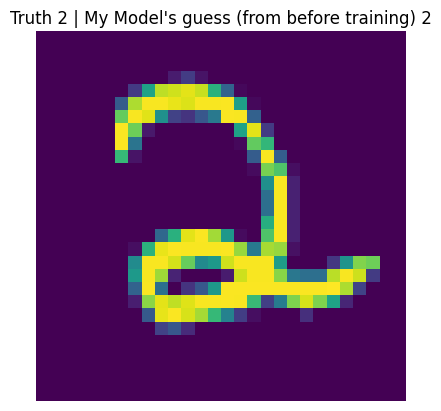

starting epoch 0
Acc: 1.0 Avg loss: 2.4079464109702737
Elapsed time for one epoch: 0.15768219996243715 seconds
starting epoch 1
Acc: 1.0 Avg loss: 2.3348942038219214
Elapsed time for one epoch: 0.14934170013293624 seconds
starting epoch 2
Acc: 1.0 Avg loss: 2.2642927433244084
Elapsed time for one epoch: 0.12302970001474023 seconds
starting epoch 3
Acc: 1.0 Avg loss: 2.1960498371199164
Elapsed time for one epoch: 0.40864289994351566 seconds
starting epoch 4
Acc: 1.0 Avg loss: 2.130077572736535
Elapsed time for one epoch: 0.12842239998281002 seconds
starting epoch 5
Acc: 1.0 Avg loss: 2.066292192805621
Elapsed time for one epoch: 0.13013429986312985 seconds
starting epoch 6
Acc: 1.0 Avg loss: 2.0046139307059945
Elapsed time for one epoch: 0.1249231998808682 seconds
starting epoch 7
Acc: 1.0 Avg loss: 1.9449668206229518
Elapsed time for one epoch: 0.4212452999781817 seconds
starting epoch 8
Acc: 1.0 Avg loss: 1.887278492969055
Elapsed time for one epoch: 0.1340860000345856 seconds
startin

In [9]:

my_model = Model(28*28, 10, [ 8, 16])
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  


img = b_x[0]
actual = b_y[0] 
plt.axis('off')
predicted = my_model.fd(np.array(img.flat))
plt.title(f"Truth {np.argmax(actual)} | My Model's guess (from before training) {np.argmax(predicted)}")
plt.imshow(img.reshape(28, 28))
plt.show()

#As you can see the model has learnt to recognize the number 9! 
datas = []
for _epoch in range(10):
    print(f"starting epoch {_epoch}")
    datas.append(my_model.train_epoch(b_x, b_y, lr=.1, timer=False, batch_timer=False))
#as you can see loss does go down and it manages to predict the single image.
#I tried really hard to get it to be able to fully train on all images, but it takes a very long time (in the hours+). 
#Intended behavior: At first, the acc (accuracy) is 0 because it has no idea what it's doing. But over time, it fits to that image and predicts that image (Acc of 1). Yay!
#Loss also does go down.

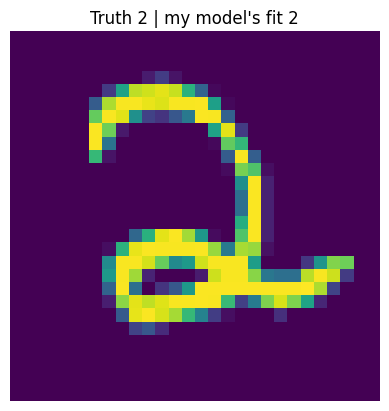

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  


img = b_x[0]
actual = b_y[0] 
plt.axis('off')
predicted = my_model.fd(np.array(img.flat))
plt.title(f"Truth {np.argmax(actual)} | my model's fit {np.argmax(predicted)}")
plt.imshow(img.reshape(28, 28))
plt.show()

#As you can see the model has learnt to recognize the number 9! 